# Toxic Comment Classification 

Team member:
- Casey Hsiung
- Marshal Ma
- Qian Qiao

## Problem Motivation

Social media and online platforms have provided a great place for individuals to express their thoughts and opinions freely. However, some comments contain negative and even explicit language, which may hurt the readers and even evolve into media violence and cyberbullying. 

To protect users and create a good atmosphere for communication, more and more platforms and companies have started to identify those toxic comments and block users who are found guilty of using unpleasant language. 

With this motivation, we decide to choose the Kaggle challenge, 'Toxic Comment Classification' as our team project. Our goal is to create a model to predict different types of toxicity for online comments, based on labels related to threats, obscenity, insults, and identity-based hate.

## Project Overview

We are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

There are 159,571 observations in the training dataset and 153,164 observations in the testing dataset.

In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk
import random

from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 

from sklearn.model_selection import train_test_split
from pre_processing.textProcessing import TextPreProcessor
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils

from keras_preprocessing.sequence import pad_sequences 
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Loading

In [3]:
train = pd.read_csv('../data/train.csv')

# Sample the data
# train = train.sample(1000, random_state=1)
labels = train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

## Traning and testing split
random.seed(923)

X_train, X_test, Y_train, Y_test = train_test_split(train.comment_text, labels, test_size = 0.25,random_state = 23)

X_train.reset_index(drop = True,inplace = True)
X_test.reset_index(drop = True,inplace = True)
Y_train.reset_index(drop = True,inplace = True)
Y_test.reset_index(drop = True,inplace = True)

print(f"Shape of the training set: {X_train.shape}")
print(f"Shape of the testing set: {X_test.shape}")

Shape of the training set: (119678,)
Shape of the testing set: (39893,)


In [4]:
Y_train.columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

## EDA

In [5]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [7]:
# Count total toxic comments

toxic_cols = train.loc[:, 'toxic':'identity_hate']
print(toxic_cols.sum())

in_row_sums = toxic_cols.sum(axis = 1)
train['empty_cat'] = (in_row_sums == 0)
print('Total comments:', len(train))
print('Total nontoxic comments:', train['empty_cat'].sum())
print('Total toxic comments:', len(train) - train['empty_cat'].sum())
print('Total labels:' , toxic_cols.sum().sum())

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
Total comments: 159571
Total nontoxic comments: 143346
Total toxic comments: 16225
Total labels: 35098


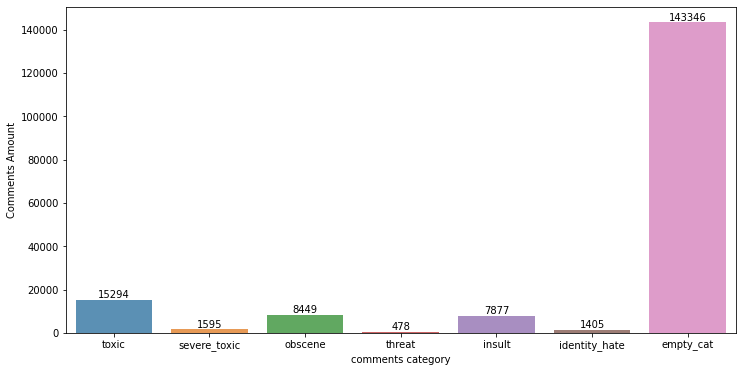

In [8]:
# Check for records that have no classifications and data imbalance

plt.figure(figsize = (12,6))
plt.rcParams['axes.unicode_minus'] = False

x = train.iloc[:,2:].sum()
ax = sns.barplot(x.index, x.values, alpha = 0.8 )
plt.xlabel('comments category')
plt.ylabel('Comments Amount')

for rect, label in zip(ax.patches, x.values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 
            height+5, label, ha='center', va='bottom')
plt.show()

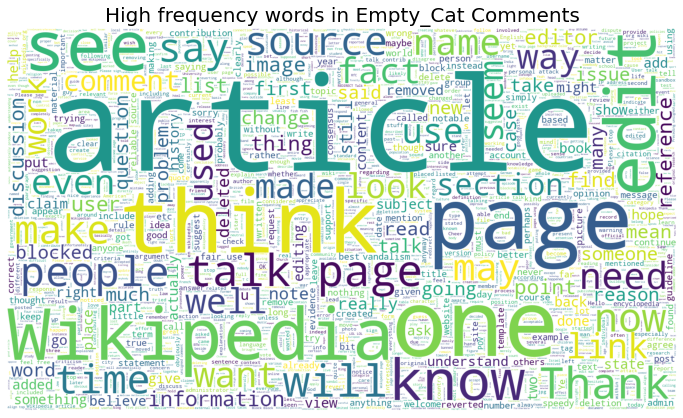

In [9]:
def wordcloud(column, colormap, value = True):
    if value: 
        subset = train[train[column] == value]
    else: 
        subset = train[train[column] == 1]
    text = subset.comment_text.values
    
    word = WordCloud(width = 1400, height =800,
                    background_color = 'white',
                    max_words = 3000,
                    random_state = 50,
                    ).generate(' '.join(text))
    plt.axis('off')
    plt.title(f'High frequency words in {column.title()} Comments', fontsize = 20)
    plt.imshow(word.recolor(colormap = colormap, random_state = 17))
    
plt.figure(figsize = (12,12))
wordcloud('empty_cat', 'viridis')

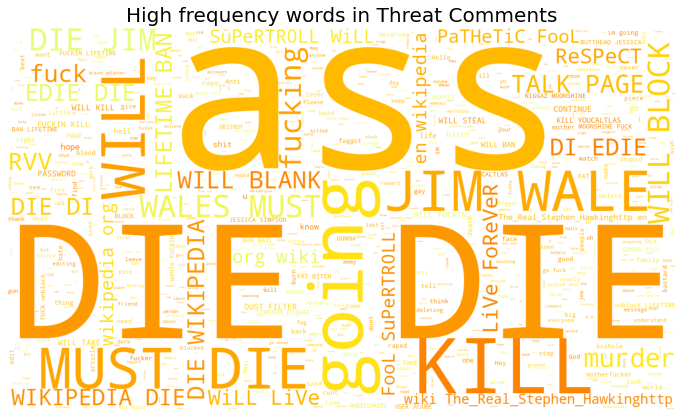

In [10]:
plt.figure(figsize = (12,12))
wordcloud('threat', 'Wistia', False)

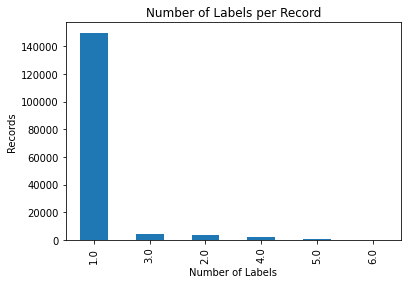

In [11]:
# Check for records that have multiple classifications
classified = train.iloc[:, 2:].sum(axis=1)

mult_class = classified.value_counts()

mult_class.plot(x=mult_class, 
             y=mult_class.values, 
             kind='bar', 
             xlabel='Number of Labels', 
             ylabel='Records')
plt.title('Number of Labels per Record')

pass

## Pre-processing

In this section, we will pre-process the data into two kinds of formats:

1. Document-Term Matrix
2. Padded numeric sequences

We will use the DTM for non RNN models, and the padded numeric sequences for recurrent neural net work based models

### Processing the documents into DTMs

In [12]:
def tokenize(text):
    """
    Define a function that take in a text and process the doc
    """
    return TextPreProcessor(text=text, lemma_flag=True, stem_flag=False).process()

# Fit a tf-idf vectorizer and filter-out the terms with less than 15 occurances or appears in more than 90% of the documents 
vec_tfidf = TfidfVectorizer(ngram_range=(1,1),tokenizer=tokenize,min_df=15, max_df=0.9)
vec_tfidf_fitted = vec_tfidf.fit(X_train)

In [13]:
X_train_DTM = vec_tfidf_fitted.transform(X_train)
X_test_DTM = vec_tfidf_fitted.transform(X_test)

In [14]:
pd.DataFrame(X_train_DTM.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,...,11275,11276,11277,11278,11279,11280,11281,11282,11283,11284
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.304312,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.057764,0.0,0.0,0.0,0.0,0.116291,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Processing the documents into padded sequences

In [15]:
VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 150
# Create the tokenizer
t = Tokenizer()
# Fit the tokenizer on the documents
t.fit_on_texts(X_train)

"""
The word index for keras Tokenizer is ordered based on frequency. Therefore we can do the following according to
https://github.com/keras-team/keras/issues/8092
"""
t.oov_token = '_unknown_'
t.word_index = {e:i for e,i in t.word_index.items() if i <= VOCAB_SIZE} # <= because tokenizer is 1 indexed
t.word_index[t.oov_token] = VOCAB_SIZE + 1

"""
Apply the tokenizer
"""
encoded_docs = t.texts_to_sequences(X_train)

"""
Padd the sequences
"""
padded_docs = pad_sequences(encoded_docs, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

print("Original text:")
print(X_train[0])
print("Vectorized:")
print(encoded_docs[0])
print("Padded:")
print(padded_docs[0])

Original text:
That's correct. A smaller diameter is held less securely by the sphincter, and is less efficient at allowing gas through.
Vectorized:
[203, 365, 5, 2894, 5001, 8, 1603, 460, 5001, 31, 1, 5001, 4, 8, 460, 5001, 34, 2946, 2853, 334]
Padded:
[ 203  365    5 2894 5001    8 1603  460 5001   31    1 5001    4    8
  460 5001   34 2946 2853  334    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 

## Modeling

### Model selections

In order to find models that perform well in text classification, our strategy is to compare different models, including non-ensemble, ensemble, and neural network models. 

- Non-ensemble: 
    - Baseline Model:Multinomial Naive Bayes
    - Logistic Regression 
    - Linear Support Vector Classifier 

- Ensemble: 
    - Random Forest
    - XGBoost

- Neural Network: 
    - Bidirectional LSTM  



### Undersampling 

Considering the imbalanced data for different classes, we decide to use undersampling techniques to remove examples from the training dataset. In the following experiments, we will compare the prediction based on original training dataset and undersampled training dataset.

In [46]:
def undersample_data(X_train, y_train):
    """
    Undersample data
    """
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

### Model performance evaluations



From the chart in EDA part, we observed that the dataset is imbalanced. Thus the proportion of correct matches (aka accuracy) would be ineffective in assessing model performance. Therefore, we will use precision, recall and macro f1 score to help us evaluate the model performance. 

In [47]:
def evaluate_classifier(y_true, y_pred, print_result=False):
    """
    Given a predicted and true value, get the performance measurement of the classifier
    """
    accr=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true,y_pred)
    recall=recall_score(y_true,y_pred) # QQ: Do we want to use weigted 
    pct_maj = max(np.mean(y_true), 1-np.mean(y_true)) # percentage of majority class
    h_loss = hamming_loss(y_true,y_pred) 
    f1 = f1_score(y_true, y_pred, average='macro') 
    
    
    if print_result:
        print(f"% majority class: {pct_maj}, Accuracy: {accr}, Precision: {precision}, Recall: {recall}, hamming_loss:{h_loss}, f1_score:{f1}")
    return (pct_maj, accr, precision, recall, h_loss, f1)




def get_model_output(model, X_train, Y_train, X_test, Y_test, model_name='', y_labels=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], undersample=False):
    """
    Automated the training and performance of traditional ML models
    """
    output = pd.DataFrame(columns=['model_name', 'label','undersampled','pct_maj_class','accr','precision','recall', 'hamming_loss','f1_score'])
    for label in y_labels:
        # Get the label to use
        y_train = Y_train[label]
        y_test = Y_test[label]
        
        if undersample:
            X, y = undersample_data(X_train, y_train)
        else:
            X, y = X_train, y_train
        
        # Fit the model
        fitted = model.fit(X, y)
        pred = fitted.predict(X_test)
        
        # Get the results
        result = [model_name, label, undersample] + list(evaluate_classifier(y_true=y_test, y_pred=pred))
        output.loc[len(output)] = result
    return output

### Model building

### Non-Ensemble Models

### Multinomial Naive Bayes Classifier

In [48]:
model1 = MultinomialNB()
non_undersampled = get_model_output(
    model1, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Naive Bayes',
    undersample=False
)

undersampled = get_model_output(
    model1, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Naive Bayes',
    undersample=True
)

multi_nb_results = non_undersampled.append(undersampled, ignore_index=True)
multi_nb_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
0,Naive Bayes,toxic,False,0.903216,0.946407,0.933132,0.480704,0.053593,0.802807
1,Naive Bayes,severe_toxic,False,0.989748,0.989823,0.565217,0.031785,0.010177,0.527534
2,Naive Bayes,obscene,False,0.947785,0.970797,0.918033,0.483917,0.029203,0.809278
3,Naive Bayes,threat,False,0.997218,0.997218,0.000000,0.000000,0.002782,0.499303
4,Naive Bayes,insult,False,0.950844,0.966611,0.848283,0.390617,0.033389,0.758800
5,Naive Bayes,identity_hate,False,0.990926,0.990976,0.750000,0.008287,0.009024,0.505930
6,Naive Bayes,toxic,True,0.903216,0.881333,0.443959,0.895623,0.118667,0.762085
7,Naive Bayes,severe_toxic,True,0.989748,0.920588,0.112391,0.977995,0.079412,0.579914
8,Naive Bayes,obscene,True,0.947785,0.890658,0.314020,0.923668,0.109342,0.703877
9,Naive Bayes,threat,True,0.997218,0.907202,0.027624,0.945946,0.092798,0.502445


### Logistic Regression

In [49]:
model2 = LogisticRegression()
non_undersampled = get_model_output(
    model2, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Logistic Regression',
    undersample=False
)

undersampled = get_model_output(
    model2, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Logistic Regression',
    undersample=True
)

logistic_regression_results = non_undersampled.append(undersampled, ignore_index=True)
logistic_regression_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
0,Logistic Regression,toxic,False,0.903216,0.957612,0.918596,0.616680,0.042388,0.857446
1,Logistic Regression,severe_toxic,False,0.989748,0.989873,0.513966,0.224939,0.010127,0.653912
2,Logistic Regression,obscene,False,0.947785,0.977715,0.903924,0.641383,0.022285,0.869344
3,Logistic Regression,threat,False,0.997218,0.997142,0.411765,0.063063,0.002858,0.553972
4,Logistic Regression,insult,False,0.950844,0.971173,0.826227,0.523712,0.028827,0.813029
5,Logistic Regression,identity_hate,False,0.990926,0.991653,0.655914,0.168508,0.008347,0.631967
6,Logistic Regression,toxic,True,0.903216,0.921941,0.562406,0.871795,0.078059,0.819603
7,Logistic Regression,severe_toxic,True,0.989748,0.957135,0.183763,0.924205,0.042865,0.642227
8,Logistic Regression,obscene,True,0.947785,0.956534,0.551399,0.898704,0.043466,0.830063
9,Logistic Regression,threat,True,0.997218,0.946933,0.042009,0.828829,0.053067,0.526322


### Linear SVC

In [50]:
model3 = LinearSVC()
non_undersampled = get_model_output(
    model3, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Linear SVC',
    undersample=False
)

undersampled = get_model_output(
    model3, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Linear SVC',
    undersample=True
)

svc_results = non_undersampled.append(undersampled, ignore_index=True)
svc_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
0,Linear SVC,toxic,False,0.903216,0.960344,0.874220,0.689459,0.039656,0.874608
1,Linear SVC,severe_toxic,False,0.989748,0.989547,0.479167,0.224939,0.010453,0.650445
2,Linear SVC,obscene,False,0.947785,0.978718,0.862941,0.704273,0.021282,0.882202
3,Linear SVC,threat,False,0.997218,0.997293,0.542857,0.171171,0.002707,0.629459
4,Linear SVC,insult,False,0.950844,0.971624,0.782165,0.585926,0.028376,0.827573
5,Linear SVC,identity_hate,False,0.990926,0.992029,0.652778,0.259669,0.007971,0.683765
6,Linear SVC,toxic,True,0.903216,0.913945,0.533385,0.885522,0.086055,0.808186
7,Linear SVC,severe_toxic,True,0.989748,0.945880,0.153053,0.943765,0.054120,0.617650
8,Linear SVC,obscene,True,0.947785,0.949289,0.507970,0.917907,0.050711,0.813325
9,Linear SVC,threat,True,0.997218,0.942346,0.042242,0.909910,0.057654,0.525488


### Compare the results for basic classifier

In [51]:
basic_methods = pd.concat([multi_nb_results, logistic_regression_results, svc_results])
basic_methods.columns = ['model_name', 'label', 'undersampled', 'pct_maj_class',
                       'accr','precision','recall','hamming_loss','f1_score']
#undersampled data 
meth_undersampled= basic_methods.loc[basic_methods['undersampled']==True]
meth_undersampled

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
6,Naive Bayes,toxic,True,0.903216,0.881333,0.443959,0.895623,0.118667,0.762085
7,Naive Bayes,severe_toxic,True,0.989748,0.920588,0.112391,0.977995,0.079412,0.579914
8,Naive Bayes,obscene,True,0.947785,0.890658,0.314020,0.923668,0.109342,0.703877
9,Naive Bayes,threat,True,0.997218,0.907202,0.027624,0.945946,0.092798,0.502445
10,Naive Bayes,insult,True,0.950844,0.888978,0.296973,0.920449,0.111022,0.693665
11,Naive Bayes,identity_hate,True,0.990926,0.898579,0.077329,0.930939,0.101421,0.544449
6,Logistic Regression,toxic,True,0.903216,0.921941,0.562406,0.871795,0.078059,0.819603
7,Logistic Regression,severe_toxic,True,0.989748,0.957135,0.183763,0.924205,0.042865,0.642227
8,Logistic Regression,obscene,True,0.947785,0.956534,0.551399,0.898704,0.043466,0.830063
9,Logistic Regression,threat,True,0.997218,0.946933,0.042009,0.828829,0.053067,0.526322


In [52]:
meth_undersampled.groupby('model_name')[['accr','precision','recall','hamming_loss','f1_score']].mean()

,accr,precision,recall,hamming_loss,f1_score
model_name,,,,,
Linear SVC,0.933823,0.288439,0.911438,0.066177,0.681567
Logistic Regression,0.942091,0.313104,0.882256,0.057909,0.695190
Naive Bayes,0.897889,0.212049,0.932437,0.102111,0.631072


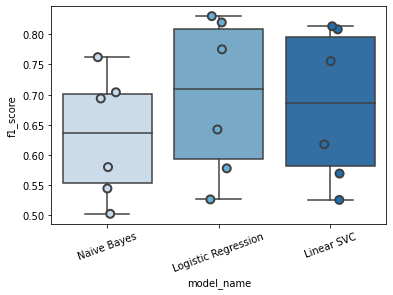

In [53]:
# Visualizing F1 score results through box-plot.
ax = sns.boxplot(x='model_name', y='f1_score', data=meth_undersampled, palette="Blues")
sns.stripplot(x='model_name', y='f1_score', data=meth_undersampled,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.show()

In [54]:
#undersampled data 
meth= basic_methods.loc[basic_methods['undersampled']==False]
meth

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
0,Naive Bayes,toxic,False,0.903216,0.946407,0.933132,0.480704,0.053593,0.802807
1,Naive Bayes,severe_toxic,False,0.989748,0.989823,0.565217,0.031785,0.010177,0.527534
2,Naive Bayes,obscene,False,0.947785,0.970797,0.918033,0.483917,0.029203,0.809278
3,Naive Bayes,threat,False,0.997218,0.997218,0.000000,0.000000,0.002782,0.499303
4,Naive Bayes,insult,False,0.950844,0.966611,0.848283,0.390617,0.033389,0.758800
5,Naive Bayes,identity_hate,False,0.990926,0.990976,0.750000,0.008287,0.009024,0.505930
0,Logistic Regression,toxic,False,0.903216,0.957612,0.918596,0.616680,0.042388,0.857446
1,Logistic Regression,severe_toxic,False,0.989748,0.989873,0.513966,0.224939,0.010127,0.653912
2,Logistic Regression,obscene,False,0.947785,0.977715,0.903924,0.641383,0.022285,0.869344
3,Logistic Regression,threat,False,0.997218,0.997142,0.411765,0.063063,0.002858,0.553972


In [55]:
meth.groupby('model_name')[['accr','precision','recall','hamming_loss','f1_score']].mean()

,accr,precision,recall,hamming_loss,f1_score
model_name,,,,,
Linear SVC,0.981592,0.699021,0.439239,0.018408,0.758009
Logistic Regression,0.980861,0.705065,0.373047,0.019139,0.729945
Naive Bayes,0.976972,0.669111,0.232552,0.023028,0.650609


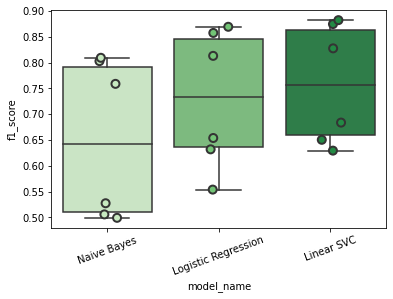

In [56]:
# Visualizing F1 score results through box-plot.
ax = sns.boxplot(x='model_name', y='f1_score', data=meth, palette="Greens")
sns.stripplot(x='model_name', y='f1_score', data=meth,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Greens")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.show()

### Hyperparameter Optimization by Grid Search - [Fell free to remove this part from the final notebook because no optimization after tuning hyperparameter]

According to the comparison of the F1 scores, Logistic Regression and Linear SVC are performing better than Naive Bayes. The next step is to compare the performance between Logistic Regression and Linear SVC with hyperparameter tuning.

There are two common ways for hyperparameter Optimization: Random Search and Grid Search. We do a grid search to find the "optimal" hyperparameters for the basic models we've chosen. Instead of tuning models for each label, we decide to use the label "Toxic" (having the largest sample size) to tune hyperparameters.

logistic_regression_classifier = LogisticRegression()
#
parameter_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                  'class_weight': [None, 'balanced']}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(logistic_regression_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train_DTM, Y_train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

svc_classifier = LinearSVC()

parameter_grid = {'class_weight': [None, 'balanced'],
                  'C': [1, 5, 6, 10]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(svc_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train_DTM, Y_train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

model2_opt = LogisticRegression(solver='newton-cg')
non_undersampled = get_model_output(
    model2_opt, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Logistic Regression',
    undersample=False
)

undersampled = get_model_output(
    model2_opt, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Logistic Regression',
    undersample=True
)

lr_opt_results = non_undersampled.append(undersampled, ignore_index=True)
lr_opt_results

model3_opt = LinearSVC(C=1)
non_undersampled = get_model_output(
    model3_opt, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Linear SVC',
    undersample=False
)

undersampled = get_model_output(
    model3_opt, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Linear SVC',
    undersample=True
)

svc_opt_results = non_undersampled.append(undersampled, ignore_index=True)
svc_opt_results

basic_methods_opt = pd.concat([lr_opt_results, svc_opt_results])
basic_methods_opt.columns = ['model_name', 'label', 'undersampled', 'pct_maj_class',
                       'accr','precision','recall','hamming_loss','f1_score']
basic_methods_opt

basic_methods_opt1 = basic_methods_opt['model_name', 'label', 'undersampled', 'f1_score','recall','precision','hamming_loss']
# #undersampled data 
meth_undersampled_opt= basic_methods_opt.loc[basic_methods_opt['undersampled']==True]
meth_undersampled_opt.groupby('model_name')[['accr','precision','recall','hamming_loss','f1_score']].mean()


meth_opt= basic_methods_opt.loc[basic_methods_opt['undersampled']==False]
meth_opt.groupby('model_name')[['accr','precision','recall','hamming_loss','f1_score']].mean()

The result of experiments shows that the macro F1 scores and Recall don't increase when tuning hyperparameters in our case. Logistic Regression performs better based on the f1 score with undersampled data.

### Decision Tree

For completeness of our analysis, we experimented with a Decision Tree classifier as a lead into the Random Forest classifier in the ensemble modeling section.

In [57]:
model = DecisionTreeClassifier()
non_undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Decision Tree',
    undersample=False
)

undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Decision Tree',
    undersample=True
)

dt_results = non_undersampled.append(undersampled, ignore_index=True)
dt_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
0,Decision Tree,toxic,False,0.903216,0.939438,0.695853,0.664854,0.060562,0.823277
1,Decision Tree,severe_toxic,False,0.989748,0.987517,0.373219,0.320293,0.012483,0.669218
2,Decision Tree,obscene,False,0.947785,0.973429,0.749391,0.737878,0.026571,0.864789
3,Decision Tree,threat,False,0.997218,0.996616,0.350000,0.252252,0.003384,0.645749
4,Decision Tree,insult,False,0.950844,0.961472,0.611579,0.592555,0.038528,0.790836
5,Decision Tree,identity_hate,False,0.990926,0.989798,0.415730,0.306630,0.010202,0.673900
6,Decision Tree,toxic,True,0.903216,0.819116,0.323811,0.798498,0.180884,0.676050
7,Decision Tree,severe_toxic,True,0.989748,0.875592,0.070215,0.909535,0.124408,0.531685
8,Decision Tree,obscene,True,0.947785,0.895119,0.319904,0.895823,0.104881,0.706617
9,Decision Tree,threat,True,0.997218,0.829419,0.012951,0.801802,0.170581,0.466010


### Ensemble Models

### Random Forest

In [58]:
model = RandomForestClassifier(n_estimators=200)
non_undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Random Forest (200 trees)',
    undersample=False
)

undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='Random Forest (200 trees)',
    undersample=True
)

rf_results = non_undersampled.append(undersampled, ignore_index=True)
rf_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
0,Random Forest (200 trees),toxic,False,0.903216,0.955130,0.909450,0.595701,0.044870,0.847743
1,Random Forest (200 trees),severe_toxic,False,0.989748,0.989898,0.562500,0.066015,0.010102,0.556541
2,Random Forest (200 trees),obscene,False,0.947785,0.979746,0.890865,0.697552,0.020254,0.885912
3,Random Forest (200 trees),threat,False,0.997218,0.997293,0.714286,0.045045,0.002707,0.541695
4,Random Forest (200 trees),insult,False,0.950844,0.969518,0.787645,0.520143,0.030482,0.805323
5,Random Forest (200 trees),identity_hate,False,0.990926,0.991201,0.617021,0.080110,0.008799,0.568694
6,Random Forest (200 trees),toxic,True,0.903216,0.886647,0.453601,0.836830,0.113353,0.761293
7,Random Forest (200 trees),severe_toxic,True,0.989748,0.902915,0.091124,0.943765,0.097085,0.557329
8,Random Forest (200 trees),obscene,True,0.947785,0.922242,0.391388,0.881421,0.077758,0.749793
9,Random Forest (200 trees),threat,True,0.997218,0.888953,0.023184,0.945946,0.111047,0.493153


### XGboost

In [59]:
model = XGBClassifier(n_estimators=200)
non_undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='XGBoost (200 trees)',
    undersample=False
)

undersampled = get_model_output(
    model, 
    X_train_DTM, 
    Y_train, 
    X_test_DTM, 
    Y_test, 
    model_name='XGBoost (200 trees)',
    undersample=True
)

xgb_results = non_undersampled.append(undersampled, ignore_index=True)
xgb_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
0,XGBoost (200 trees),toxic,False,0.903216,0.958238,0.902457,0.637400,0.041762,0.862178
1,XGBoost (200 trees),severe_toxic,False,0.989748,0.989672,0.493213,0.266504,0.010328,0.670413
2,XGBoost (200 trees),obscene,False,0.947785,0.980448,0.863358,0.743159,0.019552,0.894243
3,XGBoost (200 trees),threat,False,0.997218,0.997318,0.545455,0.216216,0.002682,0.654167
4,XGBoost (200 trees),insult,False,0.950844,0.971850,0.777116,0.599184,0.028150,0.830966
5,XGBoost (200 trees),identity_hate,False,0.990926,0.992079,0.629213,0.309392,0.007921,0.705414
6,XGBoost (200 trees),toxic,True,0.903216,0.921665,0.562373,0.859363,0.078335,0.817611
7,XGBoost (200 trees),severe_toxic,True,0.989748,0.941042,0.138444,0.909535,0.058958,0.604821
8,XGBoost (200 trees),obscene,True,0.947785,0.958815,0.565632,0.910226,0.041185,0.837801
9,XGBoost (200 trees),threat,True,0.997218,0.906174,0.024358,0.837838,0.093826,0.498999


### Ensemble Metric Analysis

In [78]:
frames = [rf_results, xgb_results]
ensemble_df = pd.concat(frames)

ens_train = ensemble_df.loc[ensemble_df['undersampled'] == False]
ens_undersam = ensemble_df.loc[ensemble_df['undersampled'] == True]

In [70]:
ens_train = ens_train.drop(columns='undersampled')
ens_train = ens_train.groupby('model_name')[['accr','precision','recall','hamming_score','f1_score']].mean()

ens_train

,model_name,accr,precision,recall,hamming_loss,f1_score
2,Random Forest (200 trees),0.893039,0.221908,0.893799,0.106961,0.629873
3,XGBoost (200 trees),0.930581,0.300864,0.874885,0.069419,0.681663


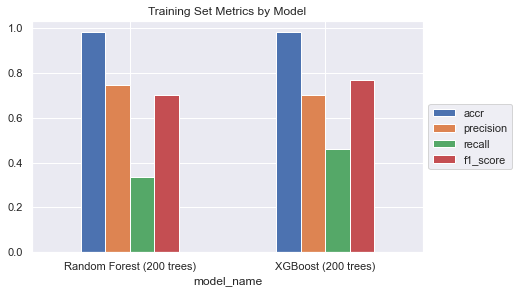

In [76]:
ens_train.plot(x='model_name', 
               y=['accr', 'precision', 'recall', 'f1_score'], 
               kind='bar', 
               title='Training Set Metrics by Model',
               rot=0
              ).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

pass

In [64]:
ens_undersam = ens_undersam.drop(columns='undersampled')
ens_undersam = ens_undersam.groupby('model_name')[['accr','precision','recall','hamming_score','f1_score']].mean()

ens_undersam

,model_name,accr,precision,recall,hamming_loss,f1_score
2,Random Forest (200 trees),0.893039,0.221908,0.893799,0.106961,0.629873
3,XGBoost (200 trees),0.930581,0.300864,0.874885,0.069419,0.681663


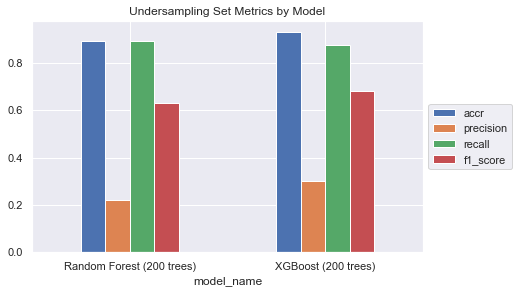

In [58]:
ens_undersam.plot(x='model_name', 
                  y=['accr', 'precision', 'recall', 'f1_score'], 
                  kind='bar', 
                  title='Undersampling Set Metrics by Model',
                  rot=0
                 ).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

pass

### Neural Network

In [30]:
"""
Model 1: Bidirectional LSTM - not undersampled
"""
def create_model(vocab_size, num_labels, sequence_length):
    model = tf.keras.Sequential([
        layers.Input(shape=(sequence_length,)),
        layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=sequence_length, mask_zero=True),
        layers.Dropout(0.4),
        layers.Bidirectional(layers.LSTM(64,return_sequences = False,dropout = 0.2,recurrent_dropout = 0.2)),
        layers.Dense(25,activation = 'relu'),
        layers.Dense(num_labels,activation = 'sigmoid')
    ])
    return model

model = create_model(len(t.word_index)+1, num_labels=6, sequence_length=MAX_SEQUENCE_LENGTH)
model.compile(
    loss=losses.binary_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

from keras.callbacks import EarlyStopping
# Define an early-stopping callback
cb = [EarlyStopping(monitor='val_loss',patience = 2)]

batch_size = 32
num_epochs = 20

model.fit(padded_docs, Y_train,validation_split=0.2,\
          batch_size=batch_size, epochs=num_epochs,verbose=1,callbacks =cb)

2022-08-01 21:31:17.936903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
2992/2992 [==============================] - 639s 212ms/step - loss: 0.0730 - accuracy: 0.9713 - val_loss: 0.0553 - val_accuracy: 0.9939
Epoch 2/20
2992/2992 [==============================] - 621s 208ms/step - loss: 0.0518 - accuracy: 0.9913 - val_loss: 0.0527 - val_accuracy: 0.9937
Epoch 3/20
2992/2992 [==============================] - 622s 208ms/step - loss: 0.0492 - accuracy: 0.9916 - val_loss: 0.0524 - val_accuracy: 0.9929
Epoch 4/20
2992/2992 [==============================] - 622s 208ms/step - loss: 0.0467 - accuracy: 0.9809 - val_loss: 0.0521 - val_accuracy: 0.9936
Epoch 5/20
2992/2992 [==============================] - 633s 211ms/step - loss: 0.0446 - accuracy: 0.9847 - val_loss: 0.0527 - val_accuracy: 0.9923
Epoch 6/20
2992/2992 [==============================] - 636s 212ms/step - loss: 0.0428 - accuracy: 0.9799 - val_loss: 0.0537 - val_accuracy: 0.9886


In [31]:
encoded_doc_test = t.texts_to_sequences(X_test)
padded_doc_test = pad_sequences(encoded_doc_test, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
pred = model.predict(padded_doc_test)

"""
Construct the final model
"""
model_name = 'Bi-LSTM + Embedding'
undersampled = False
bilstm_results = pd.DataFrame(columns=['model_name', 'label','undersampled','pct_maj_class','accr','precision','recall','hamming_loss','f1_score'])
for i in range(6):
    y_pred_bin = [x>0.5 for x in pred[:,i]]
    label = Y_train.columns[i]
    y_test = Y_test
    
    result = [model_name, label, undersampled] + list(evaluate_classifier(y_true=y_test.iloc[:,i], y_pred=y_pred_bin))
    bilstm_results.loc[len(bilstm_results)] = result

1247/1247 [==============================] - 32s 25ms/step
['Bi-LSTM + Embedding', 'toxic', False, 0.9032161030757275, 0.9609204622364826, 0.9055673009161381, 0.6656306656306656, 0.03907953776351741, 0.8729739777499108]
['Bi-LSTM + Embedding', 'severe_toxic', False, 0.9897475747624896, 0.9899731782518236, 0.51931330472103, 0.29584352078239606, 0.010026821748176372, 0.6859464809284894]
['Bi-LSTM + Embedding', 'obscene', False, 0.9477853257463715, 0.9808989045697241, 0.8255298176441597, 0.8041286605856938, 0.019101095430275987, 0.9023096036356648]
['Bi-LSTM + Embedding', 'threat', False, 0.997217556964881, 0.997217556964881, 0.0, 0.0, 0.0027824430351189432, 0.4993034201443364]
['Bi-LSTM + Embedding', 'insult', False, 0.9508435063795654, 0.9734038553129621, 0.7530933633295838, 0.6828148903620602, 0.026596144687037825, 0.8511411945371701]
['Bi-LSTM + Embedding', 'identity_hate', False, 0.9909257263179004, 0.9912014639159752, 0.5495495495495496, 0.1685082872928177, 0.008798536084024765, 0.6

In [60]:
bilstm_results

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
0,Bi-LSTM + Embedding,toxic,False,0.903216,0.960920,0.905567,0.665631,0.039080,0.872974
1,Bi-LSTM + Embedding,severe_toxic,False,0.989748,0.989973,0.519313,0.295844,0.010027,0.685946
2,Bi-LSTM + Embedding,obscene,False,0.947785,0.980899,0.825530,0.804129,0.019101,0.902310
3,Bi-LSTM + Embedding,threat,False,0.997218,0.997218,0.000000,0.000000,0.002782,0.499303
4,Bi-LSTM + Embedding,insult,False,0.950844,0.973404,0.753093,0.682815,0.026596,0.851141
5,Bi-LSTM + Embedding,identity_hate,False,0.990926,0.991201,0.549550,0.168508,0.008799,0.626751


## Consolidate results

In [61]:
all_results = pd.concat([multi_nb_results, svc_results, logistic_regression_results,rf_results,xgb_results,bilstm_results])

In [62]:
all_results.groupby(['model_name','undersampled'])[['accr','precision','recall','hamming_loss','f1_score']].mean()

accr  precision    recall  \
model_name                undersampled                                  
Bi-LSTM + Embedding       False         0.982269   0.592176  0.436154   
Linear SVC                False         0.981592   0.699021  0.439239   
                          True          0.933823   0.288439  0.911438   
Logistic Regression       False         0.980861   0.705065  0.373047   
                          True          0.942091   0.313104  0.882256   
Naive Bayes               False         0.976972   0.669111  0.232552   
                          True          0.897889   0.212049  0.932437   
Random Forest (200 trees) False         0.980464   0.746961  0.334094   
                          True          0.893039   0.221907  0.893799   
XGBoost (200 trees)       False         0.981601   0.701802  0.461976   
                          True          0.930581   0.300864  0.874885   

                                        hamming_loss  f1_score  
model_name                undersampled                          
Bi-LSTM + Embedding       False             0.017731  0.739738  
Linear SVC                False             0.018408  0.758009  
                          True              0.066177  0.681567  
Logistic Regression       False             0.019139  0.729945  
                          True              0.057909  0.695190  
Naive Bayes               False             0.023028  0.650609  
                          True              0.102111  0.631072  
Random Forest (200 trees) False             0.019536  0.700985  
                          True              0.106961  0.629873  
XGBoost (200 trees)       False             0.018399  0.769564  
                          True              0.069419  0.681663

In [63]:
# all_results.to_csv('../output/all_results.csv',index=False)

## Recommendation

In [70]:
all_results = pd.read_csv('../output/all_results.csv')

### Most performant

In [64]:
all_results.groupby(['model_name','undersampled'])[['accr','precision','recall','hamming_loss','f1_score']].mean().sort_values('f1_score', ascending=False).head(3)

,,accr,precision,recall,hamming_loss,f1_score
model_name,undersampled,,,,,
XGBoost (200 trees),False,0.981601,0.701802,0.461976,0.018399,0.769564
Linear SVC,False,0.981592,0.699021,0.439239,0.018408,0.758009
Bi-LSTM + Embedding,False,0.982269,0.592176,0.436154,0.017731,0.739738


### Highest Precision

In [65]:
all_results.groupby(['model_name','undersampled'])[['accr','precision','recall','hamming_loss','f1_score']].mean().sort_values('precision', ascending=False).head(3)

,,accr,precision,recall,hamming_loss,f1_score
model_name,undersampled,,,,,
Random Forest (200 trees),False,0.980464,0.746961,0.334094,0.019536,0.700985
Logistic Regression,False,0.980861,0.705065,0.373047,0.019139,0.729945
XGBoost (200 trees),False,0.981601,0.701802,0.461976,0.018399,0.769564


### Highest Recall

In [66]:
all_results.groupby(['model_name','undersampled'])[['accr','precision','recall','hamming_loss','f1_score']].mean().sort_values('recall', ascending=False).head(3)

,,accr,precision,recall,hamming_loss,f1_score
model_name,undersampled,,,,,
Naive Bayes,True,0.897889,0.212049,0.932437,0.102111,0.631072
Linear SVC,True,0.933823,0.288439,0.911438,0.066177,0.681567
Random Forest (200 trees),True,0.893039,0.221907,0.893799,0.106961,0.629873


### Per label best performances

In [67]:
target_label = 'toxic'
all_results[all_results.label==target_label].sort_values('f1_score', ascending=False).head(3)

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
0,Linear SVC,toxic,False,0.903216,0.960344,0.874220,0.689459,0.039656,0.874608
0,Bi-LSTM + Embedding,toxic,False,0.903216,0.960920,0.905567,0.665631,0.039080,0.872974
0,XGBoost (200 trees),toxic,False,0.903216,0.958238,0.902457,0.637400,0.041762,0.862178


In [68]:
all_results[all_results.label==target_label].sort_values('precision', ascending=False).head(3)

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
0,Naive Bayes,toxic,False,0.903216,0.946407,0.933132,0.480704,0.053593,0.802807
0,Logistic Regression,toxic,False,0.903216,0.957612,0.918596,0.616680,0.042388,0.857446
0,Random Forest (200 trees),toxic,False,0.903216,0.955130,0.909450,0.595701,0.044870,0.847743


In [69]:
all_results[all_results.label==target_label].sort_values('recall', ascending=False).head(3)

,model_name,label,undersampled,pct_maj_class,accr,precision,recall,hamming_loss,f1_score
6,Naive Bayes,toxic,True,0.903216,0.881333,0.443959,0.895623,0.118667,0.762085
6,Linear SVC,toxic,True,0.903216,0.913945,0.533385,0.885522,0.086055,0.808186
6,Logistic Regression,toxic,True,0.903216,0.921941,0.562406,0.871795,0.078059,0.819603
